## PCA

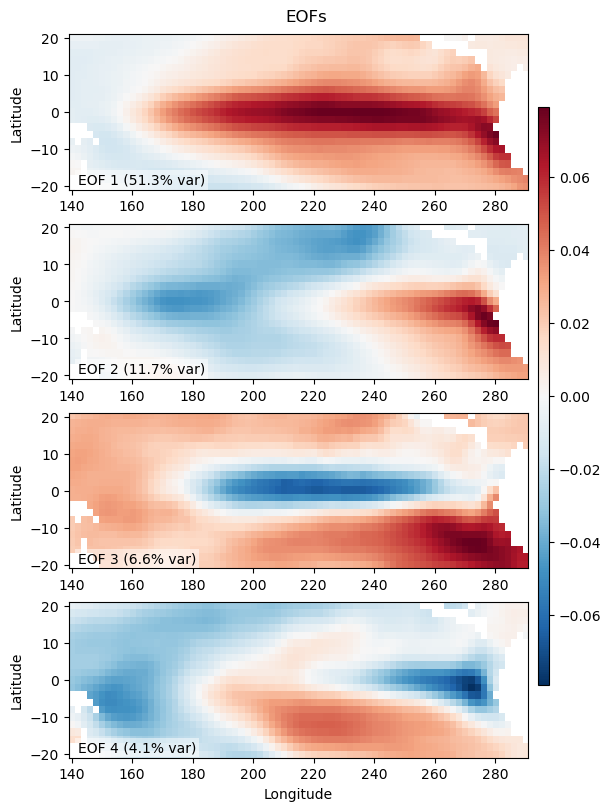

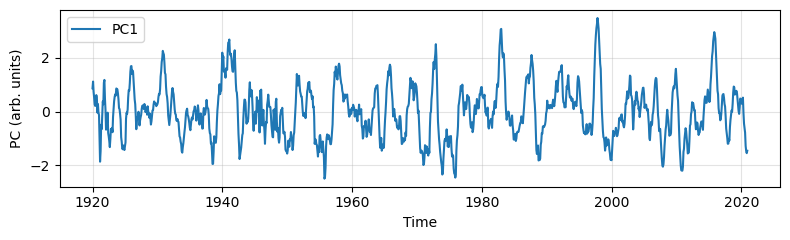

In [74]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import detrend as sp_detrend
import hvplot.xarray
import holoviews as hv
hv.extension('bokeh')
from eofs.xarray import Eof

def pca_ersstv5(
    da,
    time_slice=None,        # e.g. ("1900-01", "2024-12")
    lat_bounds=None,        # e.g. (60, -60)
    lon_bounds=None,        # e.g. (120, 290)   (0..360 in ERSST)
    remove_season=True,
    detrend_linear=False,
    n_modes=10,
    reorder_lat_ascending=False,
    nino=False,
    clim_ref=None,
):
    # ---- (Optional) reorder latitude to ascending; safer for weighting/plots ---
    if reorder_lat_ascending and (da.lat.values[0] > da.lat.values[-1]):
        da = da.sortby("lat")

    # ---- Subset time ----
    if time_slice is not None:
        da = da.sel(time=slice(*time_slice))

    # ---- Subset latitude ----
    if lat_bounds is not None:
        lo, hi = lat_bounds
        da = da.sel(lat=slice(lo, hi))

    # ---- Subset longitude ----
    if lon_bounds is not None:
        lo, hi = lon_bounds
        if lo <= hi:
            da = da.sel(lon=slice(lo, hi))
        else:
            # wrap-around case, e.g. (300, 60)
            da = xr.concat(
                [da.sel(lon=slice(lo, 360)), da.sel(lon=slice(0, hi))],
                dim="lon"
            )

    # ---- Remove seasonal cycle (monthly climatology) ----
    # if remove_season:
    #     clim = da.groupby("time.month").mean("time")
    #     anoms = da.groupby("time.month") - clim
        
    if remove_season:
        # If clim_ref is None, default to 1980-Jan to the last available time
        if clim_ref is None:
            end_time = str(da.time.max().dt.strftime("%Y-%m").item())
            clim_ref = ("1981-01", "2010-12")

        # Select the reference period for climatology
        ref = da.sel(time=slice(*clim_ref))
        if ref.time.size == 0:
            raise ValueError(f"clim_ref range {clim_ref} has no overlap with data.")

        # Compute monthly climatology over the reference period
        clim = ref.groupby("time.month").mean("time")

        # Subtract monthly climatology from all time steps
        anoms = da.groupby("time.month") - clim
    else:
        anoms = da        
        

    # ---- (Optional) linear detrend per grid cell ----
    if detrend_linear:
        def _detrend_1d(x):
            if np.all(np.isnan(x)):
                return x
            return sp_detrend(x, type="linear")
        anoms = xr.apply_ufunc(
            _detrend_1d, anoms,
            input_core_dims=[["time"]],
            output_core_dims=[["time"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[anoms.dtype]
        )

    # ---- (Optional) Nino 3.4 ----
    if nino == True:
        nino34_xy = anoms.sel(lat=slice(5, -5), lon=slice(190, 240))
        nino34_mean = nino34_xy.mean(dim=('lon', 'lat'))
        nino34 = nino34_mean.rolling(time=3, center=True).mean()
    else:
        nino34 = None
    
    # ---- Area weights: sqrt(cos(lat))  (broadcast over lon) ----
    lat_rad = np.deg2rad(anoms["lat"])
    w_lat = np.sqrt(np.cos(lat_rad))
    w2d = w_lat.broadcast_like(anoms.isel(time=0)) # Expand to 2D (lat, lon) for clean broadcasting
    
    # anoms_w = anoms * w2d
    # anoms_w = anoms_w[:, np.isfinite(anoms_w).all("time")]
    # anoms_w.mean(dim=['lon', 'lat']).plot(label='detrended')
    # plt.grid()
    # plt.legend()

    solver = Eof(anoms.transpose("time", "lat", "lon"), weights=w2d)
    EOFs = solver.eofs(neofs=n_modes)
    PCs = solver.pcs(npcs=n_modes, pcscaling=1)
    evrs = solver.varianceFraction()
    EOFs = EOFs.assign_coords(mode=np.arange(1, EOFs.sizes["mode"]+1))

    out = {
        "EOFs": EOFs,  # [mode, lat, lon] in °C units
        "PCs": xr.DataArray(PCs, coords={"time": anoms["time"], "mode": np.arange(1, n_modes+1)}, dims=["time","mode"]),
        "evrs": xr.DataArray(evrs[:n_modes], coords={"mode": np.arange(1, n_modes+1)}, dims=["mode"]),
        # "singular_values": s[:k],
        "anoms": anoms,
        "lat": anoms["lat"],
        "lon": anoms["lon"],
        "time": anoms["time"],
        "nino34": nino34,
    }
    return out

def plot_eofs(eofs, evr, modes=(1,2,3), vmin=None, vmax=None):
    modes = list(modes)
    fig, axs = plt.subplots(len(modes), 1, figsize=(6, 2*len(modes)), constrained_layout=True)
    if len(modes) == 1: axs = [axs]
    for ax, m in zip(axs, modes):
        patt = eofs.sel(mode=m)
        patt = patt.sortby("lat")
        im = patt.plot.imshow(
            ax=ax, cmap="RdBu_r", vmin=vmin, vmax=vmax,
            add_colorbar=False
        )
        ax.set_title("")
        ax.text(
            0.02, 0.02, f"EOF {m} ({evr.sel(mode=m).item()*100:.1f}% var)",
            transform=ax.transAxes, fontsize=10,
            color="black", ha="left", va="bottom",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=2)
        )
        if ax != axs[-1]:
            ax.set_xlabel("")
        else: 
            ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    cbar = fig.colorbar(im, ax=axs, orientation="vertical", aspect=50, shrink=0.8, fraction=0.1, pad=0.02)
    fig.suptitle("EOFs", fontsize=12)

def plot_pcs(pcs, modes=(1,2,3)):
    fig, ax = plt.subplots(figsize=(8, 2.5))
    for m in modes:
        ax.plot(pcs["time"].values, pcs.sel(mode=m), label=f"PC{m}")
    ax.legend()
    ax.grid(True, alpha=0.35)
    ax.set_xlabel("Time")
    ax.set_ylabel("PC (arb. units)")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    #ds = xr.open_dataset("../ENSO-data/data/sst.mnmean.nc")
    ds = xr.open_dataset("../data/sst.mnmean.nc")
    da = ds["sst"]  # ERSSTv5: 'sst'
    end_time = str(da.time.max().dt.strftime("%Y-%m").item())
    res = pca_ersstv5(
        da,
        time_slice=("1920-01", "2020-12"),
        lat_bounds=(20, -20),
        lon_bounds=(140, 290),
        remove_season=True,
        detrend_linear=True,
        n_modes=4,
        nino=True,
        clim_ref=("1981-01", "2010-12"),
    )

    plot_eofs(res["EOFs"], res["evrs"], modes=(1,2,3,4))
    plt.savefig('../figure/eofs.png')
    plot_pcs(res["PCs"], modes=(1,))

In [2]:
ds_out = xr.Dataset(
    data_vars={
        "EOFs":   res["EOFs"],     # (mode, lat, lon)
        "PCs":    res["PCs"],      # (time, mode)
        "EVR":    res["evrs"],     # (mode)
        "Nino34": res["nino34"],   # (time)
        "anom":   res["anoms"],    # (time, lat, lon) anomalies used in EOFs
    }
)
ds_out.attrs.update({
    "title": "ERSSTv5 EOF/PCA and Niño 3.4",
    "climatology_ref": "1981-01 to 2010-12",
    "notes": "EOFs computed with eofs.xarray, weights = sqrt(cos(lat))",
})

out_path = "../data/ersstv5_eof_nino34_1920_2020.nc"
ds_out.to_netcdf(out_path, format="NETCDF4")
print(f"Saved to {out_path}")

Saved to ../data/ersstv5_eof_nino34_1920_2020.nc


In [4]:
file = xr.open_dataset("../data/ersstv5_eof_nino34_1920_2020.nc")
data = file["PCs"].to_numpy()
data.shape

(1212, 4)

## Clustering

In [93]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from cluster import FCMEntropy
import xarray as xr

file = xr.open_dataset("../data/ersstv5_eof_nino34_1920_2020.nc")
data = file["PCs"].to_numpy()
train_size = 1212
test_size = 0
data = data[:train_size]

Nt, D = data.shape
features = []
features.append(data)
data_embedded = np.concatenate(features, axis=1)

# standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_embedded)

# clustering
K = 5 # number of clusters
model = FCMEntropy(num_clusters=K, m=1.8, lambda_e=.2, num_steps=1000)
results = model.fit(data_scaled, optimizer='iterative')
membership = results['membership']
centers = results['centers']
labels = np.argmax(membership, axis=1)

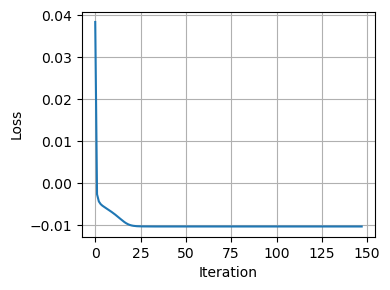

In [94]:
from plot import plot_loss
loss_history = results['loss_history']
plot_loss(loss_history)

In [95]:
membership

array([[0.31109446, 0.21711444, 0.1916398 , 0.1594495 , 0.12070181],
       [0.67612943, 0.11720477, 0.09896793, 0.04671122, 0.06098665],
       [0.6614757 , 0.12870342, 0.09183474, 0.05525308, 0.06273306],
       ...,
       [0.08110149, 0.146954  , 0.16201594, 0.27006465, 0.33986392],
       [0.07303954, 0.14883838, 0.15684945, 0.31700092, 0.3042717 ],
       [0.06805771, 0.13116541, 0.12246536, 0.41945928, 0.25885224]])

#### Regimes (hard assignment)

In [96]:
nino34 = file["Nino34"].to_numpy()

In [97]:
def reorder_labels_by_mean_nino34(nino34, labels):
    """
    Reorder integer labels so that the highest-mean Niño 3.4
    regime is label 0, next highest is label 1, etc.
    """
    labels = np.asarray(labels)
    nino34 = np.asarray(nino34)

    unique_labels = np.unique(labels)
    means = {lab: np.nanmean(nino34[labels == lab]) for lab in unique_labels}

    # Sort regime IDs by descending mean Niño 3.4
    sorted_labs = sorted(unique_labels, key=lambda x: means[x], reverse=True)

    # Map old label -> new label (0, 1, 2, ...)
    remap = {old: new for new, old in enumerate(sorted_labs)}
    new_labels = np.array([remap[lab] for lab in labels])

    return new_labels, remap, means
    
new_labels, remap, means = reorder_labels_by_mean_nino34(nino34, labels)

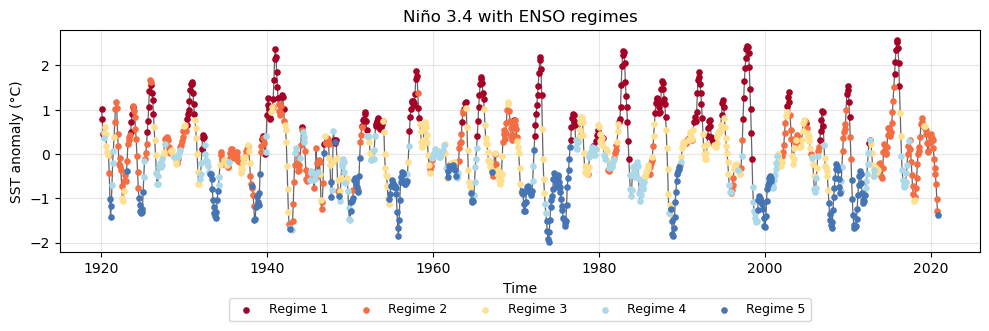

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

def plot_nino34_with_regimes(
    nino34,                   # np.ndarray, shape (Nt,)
    labels,                   # np.ndarray or list, shape (Nt,), ints like 0..K-1 (or -1 for noise)
    time=None,                # None, np.ndarray shape (Nt,), or pandas.DatetimeIndex
    regime_names=None,        # list of names per regime id; len==K
    colors=None,              # list of color strings per regime id; len==K
    rolling=None,             # e.g., 3 or 5 for moving avg window (optional)
    title="Niño 3.4 with clustered regimes"
):
    nino34 = np.asarray(nino34)
    labels = np.asarray(labels)
    assert nino34.shape == labels.shape, "nino34 and labels must have same shape"
    Nt = nino34.size
    if time is None:
        x = np.arange(Nt)
        xlabel = "Time index"
    else:
        x = np.asarray(time)
        xlabel = "Time"
        
    # Handle NaNs: mask both arrays consistently
    good = np.isfinite(nino34) & np.isfinite(labels)
    x_plot = x[good]
    y_plot = nino34[good]
    lab_plot = labels[good].astype(int)

    # Unique regimes (keep order by sorted)
    uniq = np.unique(lab_plot)

    # Build colors
    assert len(colors) >= len(uniq), "Provide enough colors for all regimes"
    palette = colors[:len(uniq)]

    # Map regime id -> color (keep label ids)
    color_map = {lab: palette[i] for i, lab in enumerate(uniq)}

    # Build names
    name_map = {lab: (regime_names[lab] if lab >= 0 else "Noise") for lab in uniq} # If regime ids start at 0..K-1, map directly; for -1 keep "Noise"

    fig, ax = plt.subplots(figsize=(10, 3.5))
    ax.plot(x, nino34, 'k', lw=0.9, alpha=0.6)
    for lab in uniq:
        sel = lab_plot == lab
        ax.scatter(x_plot[sel], y_plot[sel], s=14, color=color_map[lab], label=name_map[lab], zorder=3)
    ax.set_ylabel("SST anomaly (°C)")
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

    # Deduplicate legend entries (Niño line, rolling mean, regimes)
    handles, labels_ = ax.get_legend_handles_labels()
    seen = {}
    new_h, new_l = [], []
    for h, l in zip(handles, labels_):
        if l not in seen:
            seen[l] = True
            new_h.append(h); new_l.append(l)
    ax.legend(new_h, new_l, ncol=2, fontsize=9)
    # Legend outside bottom
    ax.legend(
        new_h, new_l,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.18),
        ncol=len(new_l),
        fontsize=9
    )

    plt.tight_layout()
    return fig, ax

colors = [
    "#a50026",  # deep red
    "#f46d43",  # orange-red
    "#fee090",  # light orange
    "#abd9e9",  # light blue
    "#4575b4",  # deep blue
]
fig, ax = plot_nino34_with_regimes(
    nino34, new_labels, time=file["time"],  # times can be pandas.DatetimeIndex
    regime_names=["Regime 1", "Regime 2", "Regime 3", "Regime 4", "Regime 5"],
    colors=colors,
    title="Niño 3.4 with ENSO regimes"
)
plt.savefig('../figure/nino34_regimes_fcm.png')
plt.show()


In [99]:
means

{0: 1.0972694, 1: -0.3692171, 2: 0.006383899, 3: -0.93047154, 4: 0.08024304}

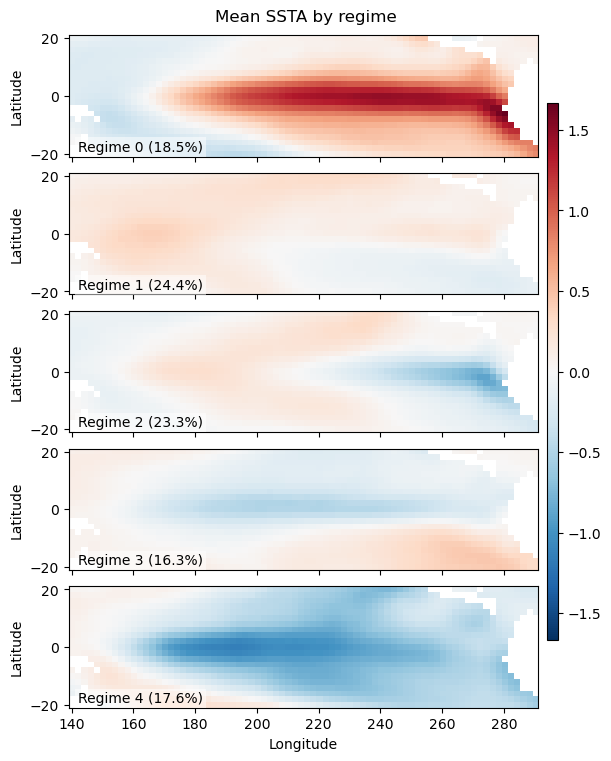

In [100]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

def mean_anom_per_regime(anom: xr.DataArray, regime_ids):
    # Ensure time is the first dim (xarray's groupby alignment will use coords anyway)
    if anom.dims[0] != "time":
        anom = anom.transpose("time", ...)

    # Make a time-aligned DataArray of regime labels
    reg = xr.DataArray(
        np.asarray(regime_ids),
        coords={"time": anom["time"]},
        dims=["time"],
        name="regime"
    )

    # Group by regime and average over time
    mean_maps = anom.groupby(reg).mean("time")  # dims -> ('regime','lat','lon')

    # Make sure the regime dim is nicely named and sorted
    mean_maps = mean_maps.rename({"regime": "regime"}).sortby("regime")
    
    # Frequency per regime
    counts = reg.groupby(reg).count()           # -> (regime,)
    counts = counts.rename("count").sortby("regime")
    total  = int(reg.count().item())
    freq   = (counts / total).rename("freq")    # fraction in [0,1]

    return mean_maps, freq  # (regime, lat, lon)

def plot_five_regime_means(mean_maps: xr.DataArray, freq: xr.DataArray, regimes=None, cmap="RdBu_r"):
    """
    Plot five regime-mean anomaly maps with a shared symmetric color scale.
    If 'regimes' is None, the first five regimes in mean_maps.regime are used.
    """
    if regimes is None:
        regimes = mean_maps.regime.values[:5]
    sel = mean_maps.sel(regime=regimes)

    vmax = float(np.nanmax(np.abs(sel.values)))
    vmin = -vmax

    fig, axs = plt.subplots(
        len(regimes), 1, figsize=(6, 1.5*len(regimes)),
        sharex=True, constrained_layout=True
    )

    if len(regimes) == 1:
        axs = [axs]
        
    frq_map = {int(r): float(freq.sel(regime=r).item()) for r in freq.regime.values}

    for ax, reg in zip(axs, regimes):
        patt = sel.sel(regime=reg)
        im = patt.plot.imshow(
            ax=ax,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False
        )
        ax.set_ylabel("Latitude")
        if ax != axs[-1]:
            ax.set_xlabel("")
        else: 
            ax.set_xlabel("Longitude")
        ax.set_title("")  # remove any auto-generated title
        r = int(reg)
        frq = frq_map.get(r, 0.0) * 100.0
        ax.text(
            0.02, 0.02, f"Regime {reg} ({frq:.1f}%)",
            transform=ax.transAxes, fontsize=10,
            color="black", ha="left", va="bottom",
            bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=2)
        )

    cbar = fig.colorbar(im, ax=axs, orientation="vertical", aspect=50, shrink=0.8, fraction=0.1, pad=0.02)
    fig.suptitle("Mean SSTA by regime", fontsize=12)

mean_maps, freq = mean_anom_per_regime(file["anom"], new_labels)
plot_five_regime_means(mean_maps, freq, regimes=[0,1,2,3,4])
plt.savefig('../figure/meanssta_regimes_fcm.png')
plt.show()